In [7]:
%load_ext autoreload
%autoreload 2

from lablr import *
from energy import *
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Random Iterations: 100%|██████████| 10/10 [00:00<00:00, 48.34it/s]
Local Iterations: 0it [00:00, ?it/s]


Lowest energy: 155.99834197986797


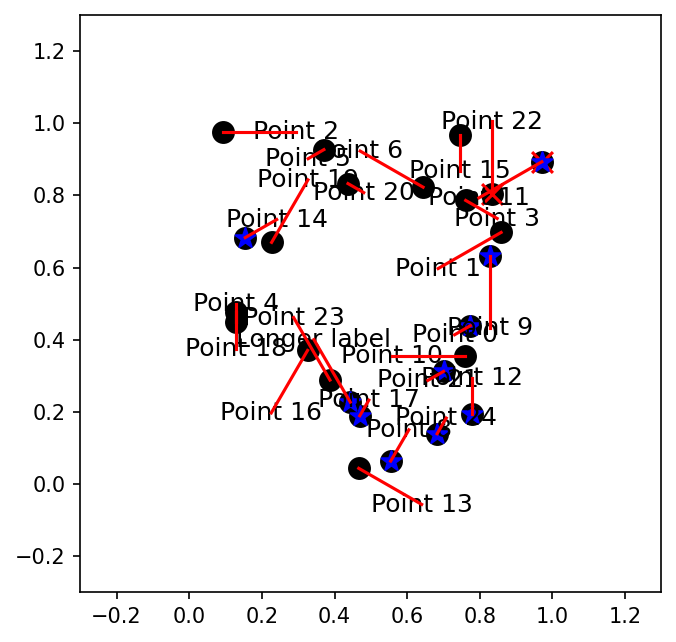

In [10]:
rand_gen = np.random.default_rng(42)
points = rand_gen.uniform(0, 1, (25, 2))
labels = [f"Point {i}" for i in range(len(points))]
labels[7] = "Longer label"

allowed_radii = [0.05, 0.1, 0.2]
allowed_angles = np.linspace(0, 360, 12, endpoint=False)

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
ax.scatter(points[:, 0], points[:, 1], s=100, c="black", zorder=1)

best_label_pos, best_label_energies, lowest_energy = optimize_label_positions(
    ax,
    points,
    labels,
    allowed_radii=allowed_radii,
    allowed_angles=allowed_angles,
    n_random_iterations=10,
    n_local_iterations=0
)

print("Lowest energy:", lowest_energy)

crossing_energies = calc_crossing_energies_old(points, best_label_pos)
overlap_energies = calc_overlap_energies_old(points, best_label_pos, labels, ax=ax)

crossing = points[crossing_energies > 0]
overlap = points[overlap_energies > 0]

ax.scatter(crossing[:, 0], crossing[:, 1], s=100, c="red", marker='x', zorder=2)
ax.scatter(overlap[:, 0], overlap[:, 1], s=100, c="blue", marker='*', zorder=2)

for i, label in enumerate(labels):
    label_pos = best_label_pos[i]
    ax.text(
        label_pos[0],
        label_pos[1],
        label,
        fontsize=12,
        ha="center",
        va="center",
        zorder=3,
    )

for i, point in enumerate(points):
    plt.plot([point[0], best_label_pos[i, 0]], [point[1], best_label_pos[i, 1]], c='r', zorder=5)

plt.xlim(-0.3, 1.3)
plt.ylim(-0.3, 1.3)
plt.show()

Explicit Testing Visualization

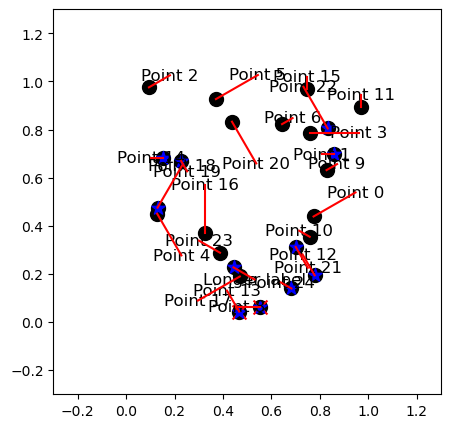

In [9]:
rand_gen = np.random.default_rng(42)
points = rand_gen.uniform(0, 1, (25, 2))
labels = [f"Point {i}" for i in range(len(points))]
labels[7] = "Longer label"

allowed_radii = [0.05, 0.1, 0.2]
allowed_angles = np.linspace(0, 360, 12, endpoint=False)

fig, ax = plt.subplots(figsize=(5, 5))

label_pos = gen_random_label_pos(points, allowed_radii, allowed_angles)

point_energies = calc_label_point_energies(
    points, label_pos, influence_extent=np.mean(allowed_radii)
)
label_energies = calc_label_label_energies(
    label_pos, influence_extent=np.mean(allowed_radii)
)
crossing_energies = calc_crossing_energies(points, label_pos)
overlap_energies = calc_overlap_energies(points, label_pos, labels, ax=ax)

energies = (
    point_energies + label_energies + crossing_energies + overlap_energies
)
total_energy = np.sum(energies)

crossing = points[crossing_energies > 0]
overlap = points[overlap_energies > 0]


plt.scatter(points[:, 0], points[:, 1], s=100, c="black", zorder=2)
plt.scatter(crossing[:, 0], crossing[:, 1], s=100, c="red", marker='x', zorder=2)
plt.scatter(overlap[:, 0], overlap[:, 1], s=100, c="blue", marker='*', zorder=2)

for i, label in enumerate(labels):
    pos = label_pos[i]
    ax.text(
        pos[0],
        pos[1],
        label,
        fontsize=12,
        ha="center",
        va="center",
        zorder=3,
    )

for i, point in enumerate(points):
    plt.plot([point[0], label_pos[i, 0]], [point[1], label_pos[i, 1]], c='r', zorder=5)

plt.xlim(-0.3, 1.3)
plt.ylim(-0.3, 1.3)
plt.show()